In [5]:
import pandas as pd
from pyspark.sql import SparkSession
from tabulate import tabulate

from utils.constants import Paths

In [4]:
spark = SparkSession.builder.appName("CSV Worker").getOrCreate()

23/12/03 20:57:15 WARN Utils: Your hostname, Doniyors-Laptop.local resolves to a loopback address: 127.0.0.1; using 10.1.161.85 instead (on interface en0)
23/12/03 20:57:15 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/03 20:57:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/12/03 20:57:16 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
23/12/03 20:57:16 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [8]:
gov_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "gov/vacant_lot_gov.parquet"))
user_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "user/vacant_311.parquet"))

In [11]:
gov_df = gov_sdf.select("Block", "InspectionDate").toPandas()
user_df = user_sdf.select("BBL","Created Date").toPandas()

/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pys

In [12]:
user_df['Block'] = user_df['BBL'].str[-5:]

In [20]:
gov_df['Block'].dtype

dtype('int32')

In [23]:
user_df['Block'] = user_df['Block'].astype(pd.Int32Dtype())

In [24]:
user_df['month'] = user_df['Created Date'].dt.to_period("M")
gov_df['month'] = gov_df['InspectionDate'].dt.to_period("M")

In [33]:
gov_df = gov_df[gov_df['InspectionDate'].dt.year >= 2010]
user_df = user_df[user_df['Created Date'].dt.year >= 2010]

In [34]:
user_complaints_by_block_month = (
    user_df.groupby(['Block', 'month']).size().reset_index(name='complaints_count')
)

gov_actions_by_block_month = (
    gov_df.groupby(['Block', 'month']).size().reset_index(name='action_count')
)

In [35]:
merged_df = pd.merge(user_complaints_by_block_month, gov_actions_by_block_month, on=['Block','month'],how='outer')

In [36]:
merged_df['action_delta'] = abs(merged_df['complaints_count'] - merged_df['action_count'])

In [37]:
merged_df = merged_df.sort_values(by='action_delta',ascending=False)

In [38]:
print(tabulate(merged_df.head(15), headers='keys', tablefmt="psql", showindex=False))

+---------+---------+--------------------+----------------+----------------+
|   Block | month   |   complaints_count |   action_count |   action_delta |
|---------+---------+--------------------+----------------+----------------|
|   10150 | 2015-08 |                  1 |             50 |             49 |
|   10040 | 2019-08 |                  1 |             24 |             23 |
|       6 | 2017-06 |                  1 |             17 |             16 |
|      35 | 2013-04 |                  1 |             16 |             15 |
|   10040 | 2019-06 |                  1 |             12 |             11 |
|      64 | 2015-06 |                  1 |              9 |              8 |
|   10059 | 2015-09 |                  1 |              9 |              8 |
|   10073 | 2016-03 |                  1 |              8 |              7 |
|   10060 | 2020-03 |                  1 |              8 |              7 |
|   10060 | 2016-04 |                  1 |              8 |              7 |

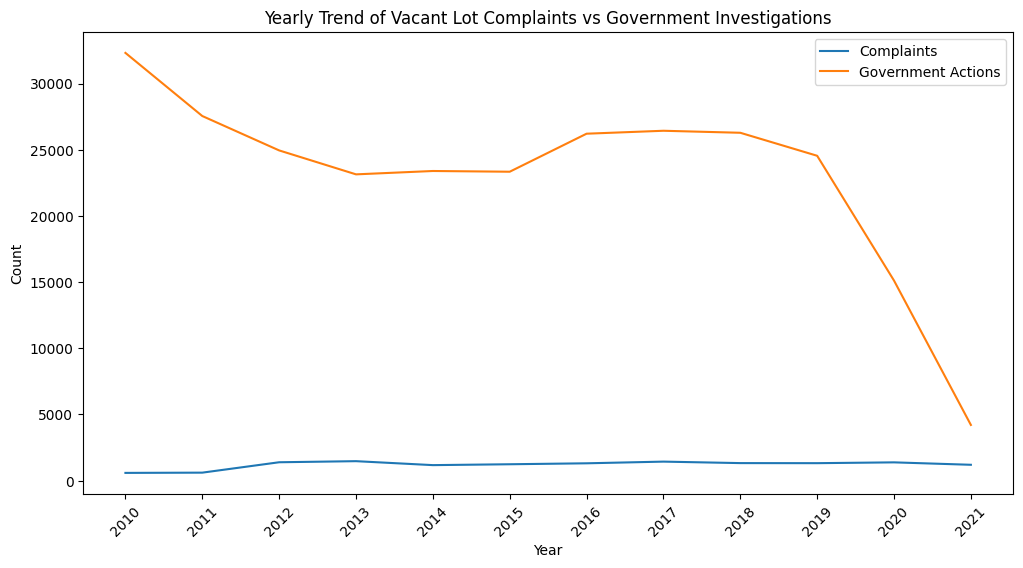

In [39]:
import matplotlib.pyplot as plt

# Extract year from 'month' for aggregation
merged_df['year'] = pd.to_datetime(merged_df['month'].astype(str)).dt.year

# Aggregate data by year
yearly_data = merged_df.groupby('year').agg({'complaints_count': 'sum', 'action_count': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['complaints_count'], label='Complaints')
plt.plot(yearly_data['year'], yearly_data['action_count'], label='Government Actions')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Trend of Vacant Lot Complaints vs Government Investigations')
plt.legend()
plt.xticks(yearly_data['year'], rotation=45)  # Ensure all years are displayed as x-ticks

plt.show()